we import all the modules and libraries that we will need to build the classifier

In [2]:
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import FreqDist, NaiveBayesClassifier

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

import string
import matplotlib.pyplot as pt
from random import seed,shuffle


Next we import the Corpus that we want to classify. In our case we select the genesis Corpus that contains several language versions of the first Book of the bible
We select three languages: english,finnish and portuguese. This way we can classify the corpus in english and non english having different languages
Of course we will need to get the stopwords for this languages.

Also we need to prepare all the features we will use to analyze the corpus that are stemmer and lemmatizer

In [1]:
from nltk.corpus import genesis

After deciding the corpus we need to build up the pipeline that processes the text.
As shown below we define 4 functions that implement part of the pipeline. In the specific:

1) sent_feat(sent:list[str])
Given a sentence (list of strings) we determine if it contains or not the topFreq words.
Depending on the words that the sentence contains(which appear as true in this list) we will determine if the sentence we are analyzing is in English or in non-English.

2) setLabel(Corpus:list[str],label:int)
in this function we set for each sentence a label (0 or 1) that represents respectively non-English and English. We will need to mantain these labels to determine various statistics and metrics of our classifier.

3) split(set: list[str],train_set:float)
this function splits the entirety of the corpus in trainig and testing sets. The proportion of how much of the corpus is assigned as train set is determined by the train_set float value.

4) Proc_corp(corp_name:str,corp_lang:str)
Given the corp_name (which text we are going to processes) and the corp_lang(the language in which this text it's written) we start to processes the corpus.

In [3]:
def sent_feat(sent:list[str]):
    return{f'contains({word})':(word in set(sent))for word in topFreq}

def setLabel(Corpus:list[str],label:int):
    labels = [label for _ in range(len(Corpus))]
    labeled_sents = [sent_feat(sent)for sent in Corpus]
    return list(zip(labeled_sents,labels))

def split(set: list[str],train_set:float):
    #index is the threshold that we wil use to divide the entire set of sentences in training and testing set
    index = int((train_set/100)*len(set))
    return set[:index],set[index:]

def Proc_corp(corp_name:str,corp_lang:str):
    #we initialize all the needed structures to process each corpora
    
    # corp: is the actual corpus that we are going to processes
    # sents: is the tokenization by sentences of corp
    # sent_tok : is the ulterior word tokenization on each sentence. In this way we can processes the words and than rebuild the sentences usig the processed words
    # stopW : knowing the language in which the text is written we can remove the stop words of that language.
    # processed_sents : the final list of all sentences built with the processed words
    
    corp = genesis.raw(corp_name)
    sents = sent_tokenize(corp)
    sent_tok = [word_tokenize(sent) for sent in sents]
    stopW =stopwords.words(corp_lang)
    processed_sents = []
    
    #we loop over all sentences and for each one we:
        #select all string(words) that are not present in puntuaction, numbers and stop words
        #if a word doesn't appear in this 3 groups we can apply stemming and lemmatization(in the specific we use the Porter stemmer and the WordNetLemmatizer)
        #after processing, each word is than appended to 2 list:
            #1)sent_plus which is the new sentence built with the processed words
            #2)all_words which will contain all the words that we process. We will need this to select the most frequent words.
        #once we finish building one new sentence we append the forementioned sentece to processed_sents list
    for i in range(len(sent_tok)):
        sent = sent_tok[i]
        sent_plus = []
        
        for j in range(len(sent)):
            w = sent[j]
            if(w not in string.punctuation)and(not w.isnumeric()) and (w.casefold() not in stopW):
                stemedW=stemmer.stem(w)
                lemmedW = lemma.lemmatize(stemedW)
                sent_plus.append(lemmedW)
                all_words.append(lemmedW)
            processed_sents.append(sent_plus)
    return processed_sents

In this next cell we implement the main function. 
In this function we define:

    -corps: the list of texts we get from our imported corpus
    
    -langs: which languages this texts are written in
    
    -stemmer and lemmatizer(abbreviated as lemma in the code)
    
    -the lists all_words,setSent and dataset
    
    -freqs : frequency distribution of all the words in the all_words list
    
    -topFreq : a list of the top n frequent words. We will use this top frequent words to determine if a sentence is written in English or not


In [4]:
if __name__ == "__main__":
    langs=['english','finnish','portuguese']
    corps=['english-kjv.txt','finnish.txt','portuguese.txt']
    stemmer = PorterStemmer()
    lemma = WordNetLemmatizer()
    
    all_words=[]
    setSent=[]
    dataset=[]
    
    for i, value in enumerate(corps):
        setSent.append(Proc_corp(value,langs[i]))
    
    freqs = FreqDist(all_words)
    topFreq = list(freqs)[:1500]
    
    for i,corp in enumerate(setSent):
        if i<2:
            dataset.extend(setLabel(corp,1))
        else:
            dataset.extend(setLabel(corp,0))
    seed(1)
    #we shuffle the dataset so that both english labeled sentences and non-engish labeled ones will appear in both train_set and test_set when we use the split function
    shuffle(dataset)
    
    train_set,test_set = split(dataset,75)
    classifier = NaiveBayesClassifier.train(train_set)
    
    # this lists will contain the real label associated to a sentence (label_r) and the label the classifier will assign (label_pred)
    #we will use this two lists to compute Accuracy,Precision,Recall and F1 scores and also to later plot the confusion matrix
    label_r=[]
    label_pred=[]
    
    for i,(sent,lab) in enumerate(test_set):
        label_r.append(lab)
        label_pred.append(classifier.classify(sent))
    
    conf_m=confusion_matrix(y_true = label_r,y_pred = label_pred)
    
    #here we print the metrics that tell us if our classifier is doing well in classifing English and non-English sentences
    print('Accuracy: %.6f' % accuracy_score(label_r,label_pred))
    print('Precision:%.6f' % precision_score(label_r,label_pred))
    print('Recall:%.6f' % recall_score(label_r,label_pred))
    print('F1 : %.6f' % f1_score(label_r,label_pred))
    
    


Accuracy: 0.993263
Precision:1.000000
Recall:0.989446
F1 : 0.994695


After computing the statistics we plot the confusion matrix using our results

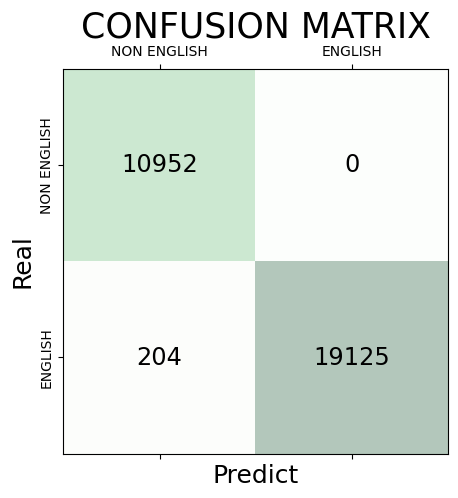

In [7]:
fig, ax = pt.subplots(figsize=(5, 5))
ax.matshow(conf_m, cmap=pt.cm.Greens, alpha=0.3)
    
ax.set_xticks(ticks=[0, 1], labels=['NON ENGLISH', 'ENGLISH'])
ax.set_yticks(ticks=[0, 1], labels=['NON ENGLISH', 'ENGLISH'], rotation=90, va='center')
    
for i in range(conf_m.shape[0]):
     for j in range(conf_m.shape[1]):
            ax.text(x=j, y=i, s=conf_m[i, j], va='center', ha='center', size='xx-large')

# set title and label for plotting
pt.title('CONFUSION MATRIX', fontsize=25)
pt.xlabel('Predict', fontsize=18)
pt.ylabel('Real', fontsize=18)
pt.show()